In [1]:
# coding='utf-8'
import os
import sys
import numpy as np
import time
import datetime
import json
import importlib
import logging
import shutil
import random

import matplotlib
matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib.ticker import NullLocator
# from PIL import Image
import torch
import torch.nn as nn

from yolo_model import yoloModel
from PASCAL_Dataloader import create_split_loaders
from YOLO_Loss import YoloLoss
from utils import NMS, remove_nulls, convert_to_xywh
from bbox import non_max_suppression
from detect import plot_detections

%matplotlib inline

In [2]:
config = {}
config["batch_size"] = 16
config['backbone_name'] = "darknet_53"
config['backbone_pretrained'] = ""
config['anchors'] = [[[116, 90], [156, 198], [373, 326]],
                            [[30, 61], [62, 45], [59, 119]],
                            [[10, 13], [16, 30], [33, 23]]]
config['classes'] = 20
config['img_h'] = config['img_w'] = 416
config['confidence_threshold'] = 0.5
config['nms_threshold'] = 0.4

'''
UPDATE THESE VALUES!

'''
config['pretrain_snapshot'] = "./states/20190531004422/model.pth" # "./states/20190530222509/model.pth"
config['root_dir'] = './VOC2012'
config['output_dir'] = './detected_images/'

_, _, test_loader = create_split_loaders(root_dir=config['root_dir'], batch_size=config['batch_size'])
print('There are %d batches in test set. This only runs the first batch.' %len(test_loader))

There are 130 batches in test set. This only runs the first batch.


In [3]:
def demo(config, test_loader, output_dir=config['output_dir']):   
    # Load and initialize network
    net = yoloModel(config).cuda()

    # Restore pretrain model
    if config["pretrain_snapshot"]:
        print('Loading model...')
        logging.info("load checkpoint from {}".format(config["pretrain_snapshot"]))
        state_dict = torch.load(config["pretrain_snapshot"])
        net.load_state_dict(state_dict)
    else:
        raise Exception("missing pretrain_snapshot!!!")


    # YOLO loss with 3 scales
    yolo_losses = []
    for i in range(3):
        yolo_losses.append(YoloLoss(config["classes"], (config["img_w"], config["img_h"]), config["anchors"][i]))
        
    # Start inference
    print('Ready for detections!')             
    for batch, sample in enumerate(test_loader):
        if batch >=1:
            print('\nbreaking')
            break
            
        images, labels = sample["image"], sample["label"]
        orig_W, orig_H = sample["orig_img"][0], sample["orig_img"][1]
        target_labels = sample["target_label"]
        imgfiles = sample["imgfile"]
        
        # Create image pathfiles
        imgpaths = [os.path.join(config["root_dir"], 'JPEGImages', x) for x in imgfiles]
        
        orig_W = orig_W.to('cpu').numpy()
        orig_H = orig_H.to('cpu').numpy()
        images = images.cuda()
        
        # Run images through model, get predictions, and apply NMS.
        with torch.no_grad():
            outputs = net(images)
            output_list = []
            for i in range(3):
                output_list.append(yolo_losses[i](outputs[i]))
            detections = torch.cat(output_list, 1)
            detections = non_max_suppression(detections, 20)

        for ii, detection in enumerate(detections): ## 0 to 15
        # ------------------------------------- #
        # Parsing targets and detections labels #
        # ------------------------------------- #
            print('\nbatch %d, sample %d' %(batch,ii))
            targets = convert_to_xywh(remove_nulls(target_labels[ii,:].to('cpu').numpy())) #70x5
#             print('target labels (cls, x, y, w, h)\n', targets)           
            
            if detection is not None:
                # Rescale coordinates to original dimensions
                RATIO_W = orig_W[ii] / config["img_w"]
                RATIO_H = orig_H[ii] / config["img_h"]
            
                predictions = np.zeros((len(detection),5), dtype=int)
                for jj, (x1, y1, x2, y2, conf, cls_conf, cls_pred) in enumerate(detection):        
                    x = int(x1 * RATIO_W)
                    y = int(y1 * RATIO_H)
                    w = int(abs(x2 - x1) * RATIO_W)
                    h = int(abs(y2 - y1) * RATIO_H)
                    predictions[jj,:] = (int(cls_pred), x, y, w, h) 
#                 print('predicted labels (cls, x, y, w, h)\n', predictions)
                
            else:
                predictions = []
#                 print('predicted labels (cls, x, y, w, h) - No objects detected!!')
            
             # ----------------------------------------- #
            # Plot targets and detections bounding boxes #
            # ------------------------------------------ #
            plot_detections(imgpaths[ii], targets, predictions, \
                        batch=batch, sample=ii, output_dir=output_dir, is_demo=True)
    
    print('Finished object detections! Check the results.')
    



Loading model...
Ready for detections!

batch 0, sample 0

batch 0, sample 1

batch 0, sample 2

batch 0, sample 3

batch 0, sample 4

batch 0, sample 5

batch 0, sample 6

batch 0, sample 7

batch 0, sample 8

batch 0, sample 9

batch 0, sample 10

batch 0, sample 11

batch 0, sample 12


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



batch 0, sample 13

batch 0, sample 14

batch 0, sample 15

breaking
Finished object detections! Check the results.


<Figure size 432x288 with 0 Axes>

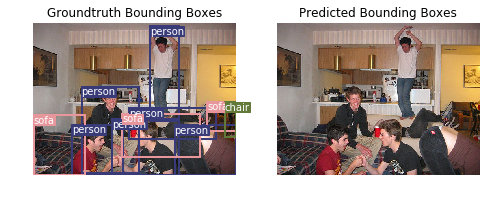

<Figure size 432x288 with 0 Axes>

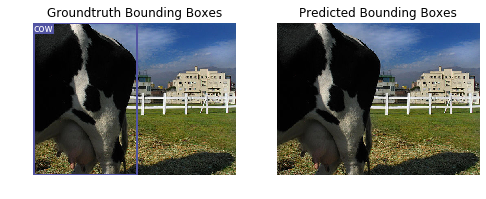

<Figure size 432x288 with 0 Axes>

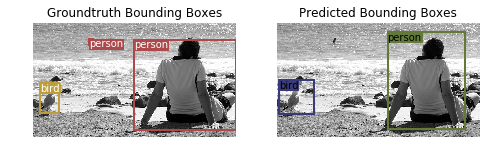

<Figure size 432x288 with 0 Axes>

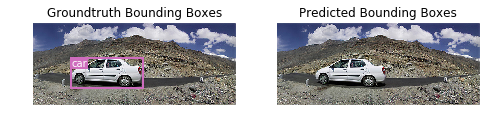

<Figure size 432x288 with 0 Axes>

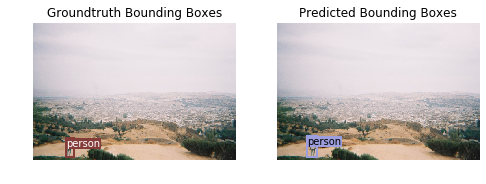

<Figure size 432x288 with 0 Axes>

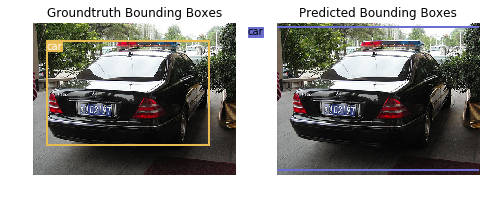

<Figure size 432x288 with 0 Axes>

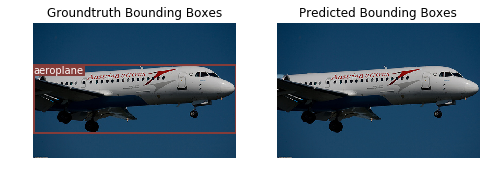

<Figure size 432x288 with 0 Axes>

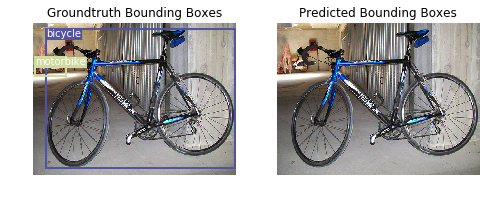

<Figure size 432x288 with 0 Axes>

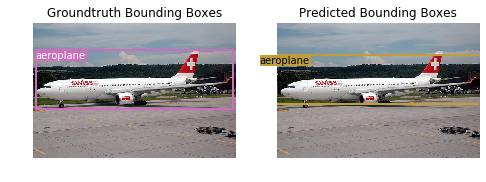

<Figure size 432x288 with 0 Axes>

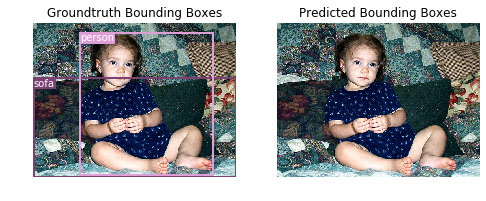

<Figure size 432x288 with 0 Axes>

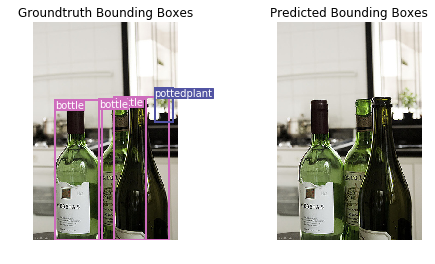

<Figure size 432x288 with 0 Axes>

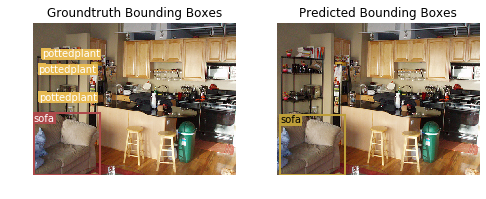

<Figure size 432x288 with 0 Axes>

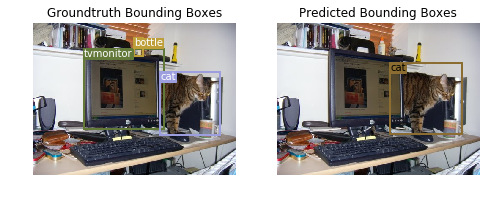

<Figure size 432x288 with 0 Axes>

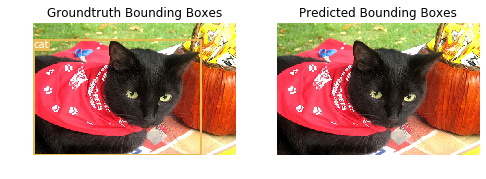

<Figure size 432x288 with 0 Axes>

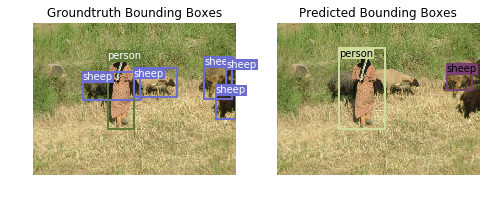

<Figure size 432x288 with 0 Axes>

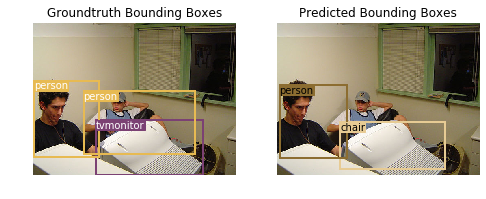

In [4]:
if __name__ == "__main__":
    demo(config,test_loader)